# AM2.5 spin up

# Setup

In [1]:
import os
import shutil
import glob
import pandas as pd
import numpy as np
import xarray as xr
import xgcm
import pickle as pkl

import cartopy
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.path as mpath

import cmocean.cm as cmo

In [2]:
## some magic to automatically reload my functions before running a new cell
%load_ext autoreload
## %reload_ext autoreload
%autoreload 1
%aimport my_functions

import my_functions as mf

## Figure settings

In [3]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 140

# %config InlineBackend.figure_formats = ['pdf']
%config InlineBackend.figure_formats = ['png']

# Get data

In [12]:
ftype = {
    'alb_sfc': 'atmos_month',
    'rh': 'atmos_month',
    'ucomp': 'atmos_month',
    'vcomp': 'atmos_month',
    'temp': 'atmos_month',
    'sphum': 'atmos_month',
    'omega': 'atmos_month',
    'cloud_amt': 'atmos_month',
    't_surf': 'atmos_month',
    'tau_x': 'atmos_month',
    'tau_y': 'atmos_month',
    'ice_mask': 'atmos_month',
    'land_mask': 'atmos_month',
    'evap': 'atmos_month',
    'precip': 'atmos_month',
    'ps': 'atmos_month',
    'WVP': 'atmos_month',
    'species': 'land_inst_month',
    'status': 'land_inst_month',
    'swup_dir': 'land_month',
    'swup_dif': 'land_month',
    'swdn_dir': 'land_month',
    'swdn_dif': 'land_month',
    'stomatal_cond': 'land_month',
    'sens': 'land_month',
    'vegn_LAI': 'land_month',
    'vegn_height': 'land_month',
    'bl': 'land_month',
    'transp': 'land_month',
    'grid_yt': 'atmos_month',
    'grid_xt': 'atmos_month'
}


def getoutput(expname, variable, getAll=False):
    runpath = '/tiger/scratch/gpfs/GEOCLIM/bgb2/AM2.5/work/'+expname+'_tigercpu_intelmpi_18_540PE/POSTP/'
    if getAll:
        return xr.open_mfdataset(runpath+'*.'+variable+'.nc')
    else:
        print(runpath+'*.'+ftype[variable]+'.nc')
        return xr.open_mfdataset(runpath+'*.'+ftype[variable]+'.nc')[variable]

In [26]:
lai = getoutput('intvegCTL1990s-50yr', 'vegn_LAI')
biom = getoutput('intvegCTL1990s-50yr', 'bl')
spec = getoutput('intvegCTL1990s-50yr', 'species')
tran = getoutput('intvegCTL1990s-50yr', 'transp')
stcon = getoutput('intvegCTL1990s-50yr', 'stomatal_cond')
tsrf = getoutput('intvegCTL1990s-50yr', 't_surf')

lmask = getoutput('intvegCTL1990s-50yr', 'land_mask').isel(time=0)
bool_lmask = xr.where(lmask >= 0.15, 1, 0)

/home/bgb2/miniconda3/envs/itcz_phys/lib/python3.11/site-packages/xarray/coding/times.py:716: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/bgb2/miniconda3/envs/itcz_phys/lib/python3.11/site-packages/xarray/coding/times.py:716: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/bgb2/miniconda3/envs/itcz_phys/lib/python3.11/site-packages/xarray/coding/times.py:716: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/hom

In [42]:
atmos_month = getoutput('intvegCTL1990s-50yr', 'atmos_month', getAll=True)
land_month = getoutput('intvegCTL1990s-50yr', 'land_month', getAll=True)

/home/bgb2/miniconda3/envs/itcz_phys/lib/python3.11/site-packages/xarray/coding/times.py:716: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/bgb2/miniconda3/envs/itcz_phys/lib/python3.11/site-packages/xarray/coding/times.py:716: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/bgb2/miniconda3/envs/itcz_phys/lib/python3.11/site-packages/xarray/coding/times.py:716: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/hom

In [7]:
atmosgrid = xgcm.Grid(atmos_month, coords={'grid_xt': {'center': 'grid_xt'},
                                           'grid_yt': {'center': 'grid_yt'},
                                           'pfull': {'center': 'pfull'} })

landgrid = xgcm.Grid(land_month, coords={'grid_xt': {'center': 'grid_xt'},
                                          'grid_yt': {'center': 'grid_yt'},
                                          'zfull_soil': {'center': 'zfull_soil'} })

# Explore

## Vegetation fields

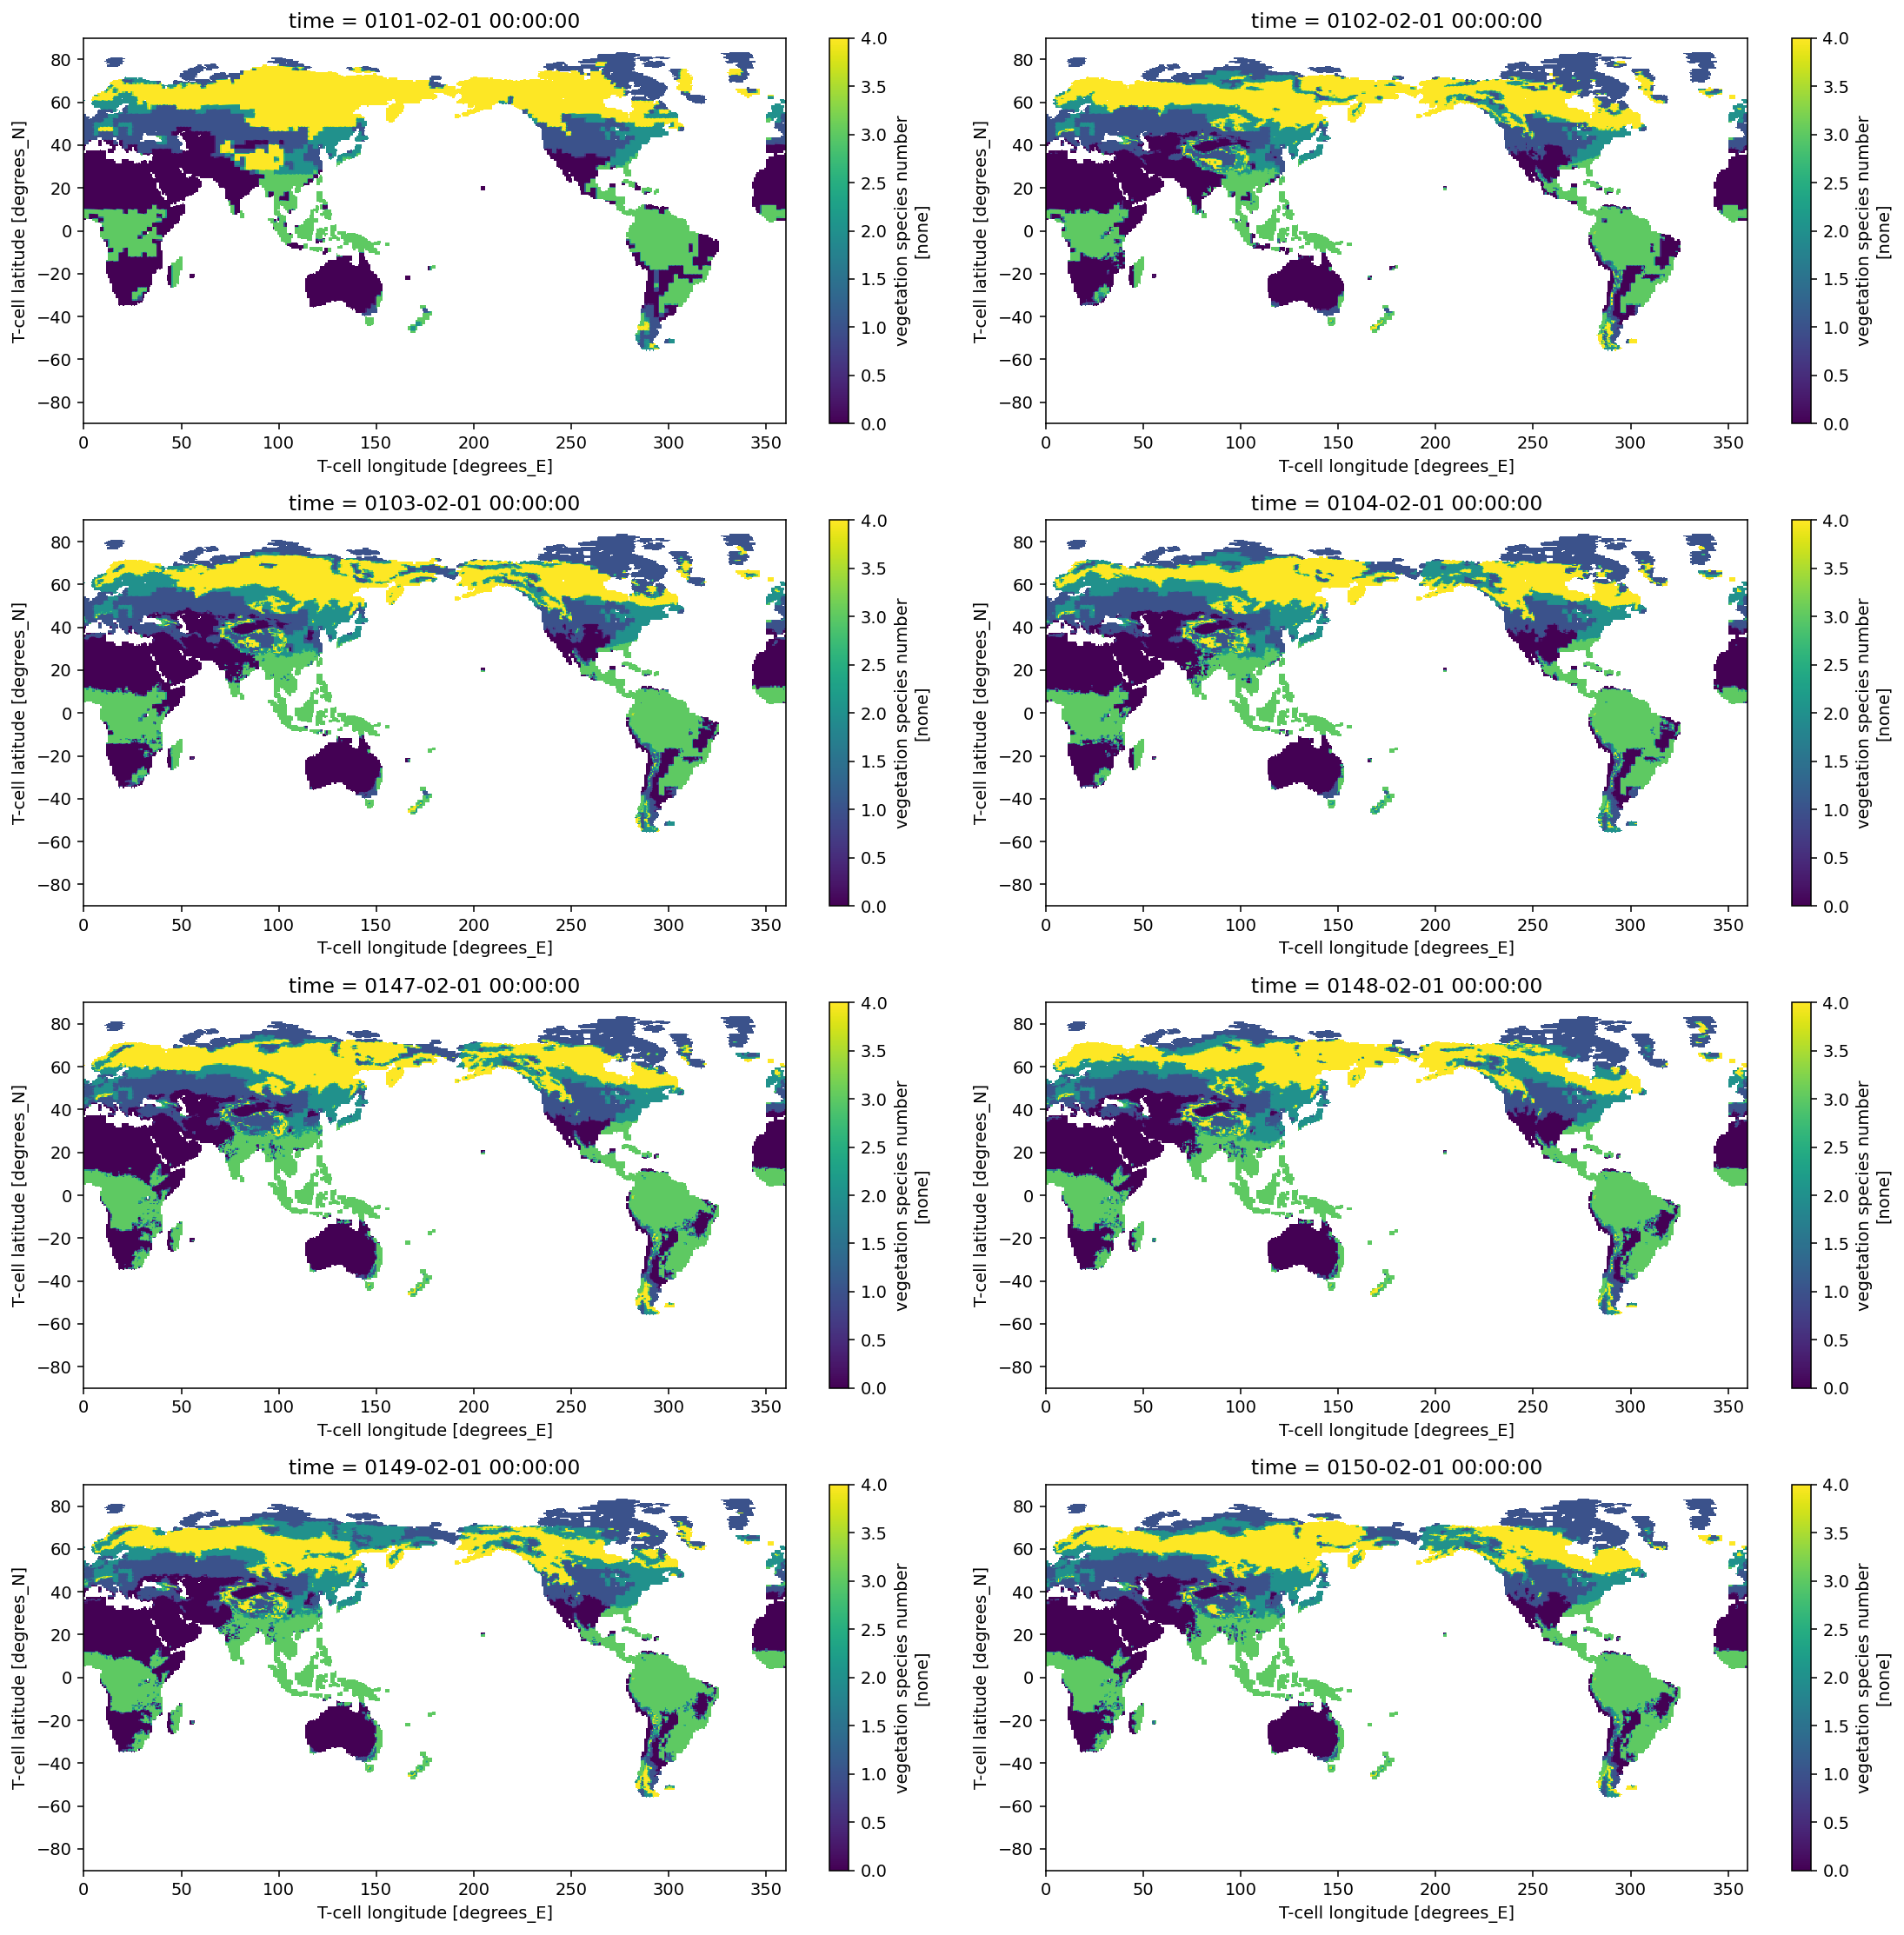

In [129]:
fig,axes = plt.subplots(4,2,figsize=(16,16))
ax = axes.ravel()

spec.isel(time=0).plot.pcolormesh(ax=ax[0])
spec.isel(time=1*12).plot.pcolormesh(ax=ax[1])
spec.isel(time=2*12).plot.pcolormesh(ax=ax[2])
spec.isel(time=3*12).plot.pcolormesh(ax=ax[3])

spec.isel(time=46*12).plot.pcolormesh(ax=ax[4])
spec.isel(time=47*12).plot.pcolormesh(ax=ax[5])
spec.isel(time=48*12).plot.pcolormesh(ax=ax[6])
spec.isel(time=49*12).plot.pcolormesh(ax=ax[7])

fig.tight_layout()

In [12]:
def getzonal(da):
    coslat_weights = np.cos(land_month.grid_yt * np.pi / 180)
    zonal = da.mean(dim='grid_xt') * coslat_weights
    return zonal

def getglobmean(da):
    coslat_weights = np.cos(land_month.grid_yt * np.pi / 180)
    zonal = da.mean(dim='grid_xt') * coslat_weights
    globmean = zonal.sum(dim='grid_yt') / coslat_weights.sum()
    return globmean

def is_djf(month):
    return (month >= 12) | (month <= 2)

def is_jja(month):
    return (month >= 6) | (month <= 8)

def is_jas(month):
    return (month >= 7) | (month <= 9)

def is_month(month, m):
    return month == m

In [9]:
lai_zonal = getzonal(lai)
lai_globmean = getglobmean(lai)

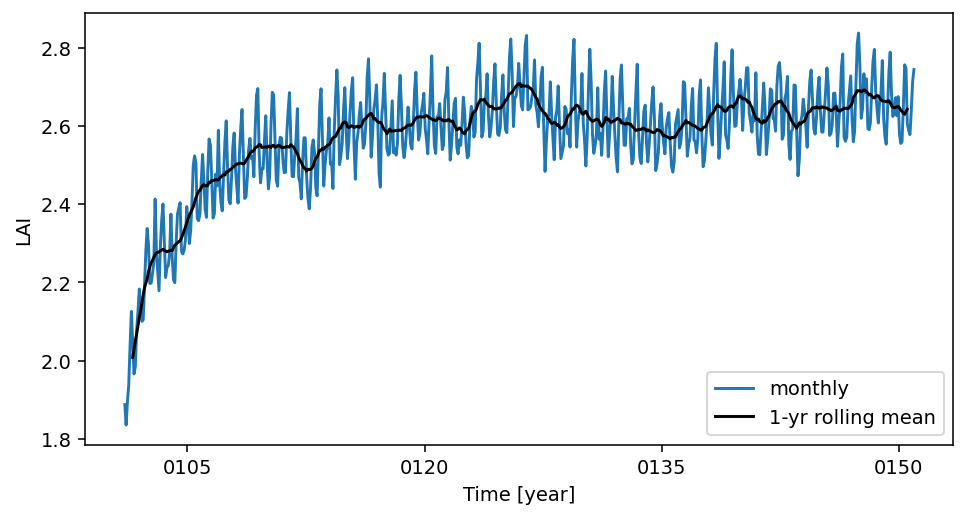

In [10]:
fig,ax = plt.subplots(figsize=(8,4))

lai_globmean.plot(ax=ax, label='monthly')
lai_globmean.rolling(time=12, center=True).mean().plot(ax=ax, c='k', label='1-yr rolling mean')
ax.set_ylabel('LAI')
ax.set_xlabel('Time [year]')
ax.legend(loc='lower right')

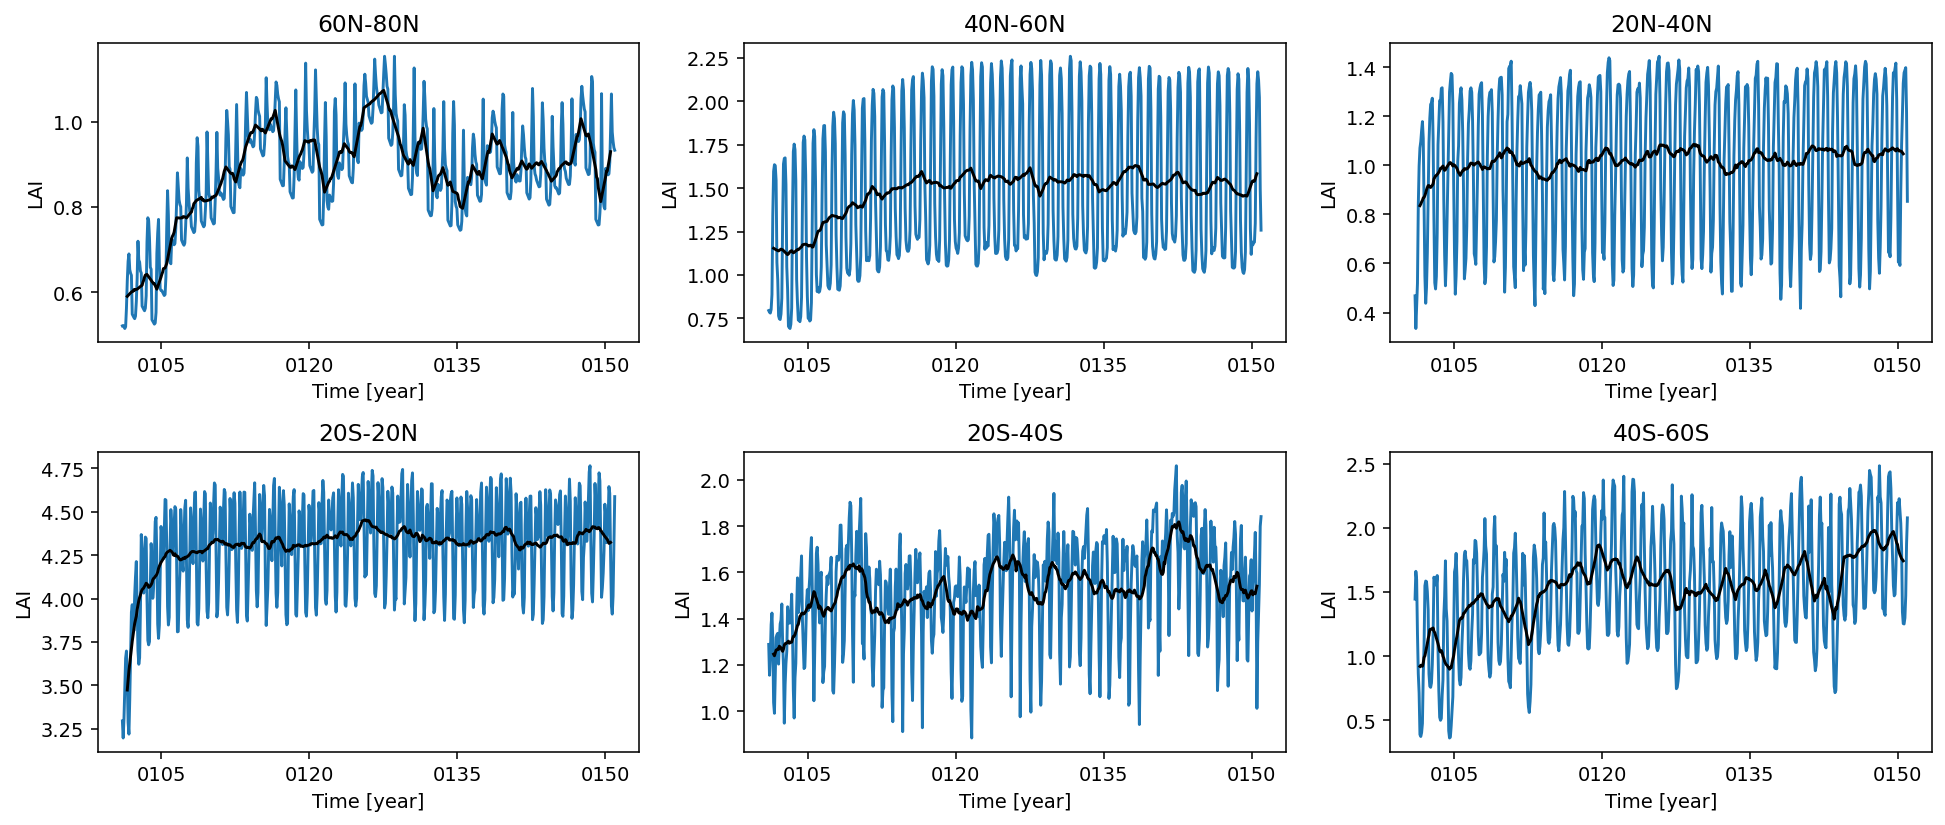

In [131]:
shgh = slice(-60,-40)
smid = slice(-40,-20)
trop = slice(-20,20)
nmid = slice(20,40)
nhgh = slice(40,60)
npol = slice(60,80)

fig,axes = plt.subplots(2, 3, figsize=(14,6))
ax = axes.ravel()

# peaks in JAS
lai_zonal.sel(grid_yt=npol).mean(dim='grid_yt').plot(ax=ax[0], label='monthly')
lai_zonal.sel(grid_yt=npol).mean(dim='grid_yt').rolling(time=12, center=True).mean().plot(ax=ax[0], c='k', label='1-yr rolling mean')

lai_zonal.sel(grid_yt=nhgh).mean(dim='grid_yt').plot(ax=ax[1], label='monthly')
lai_zonal.sel(grid_yt=nhgh).mean(dim='grid_yt').rolling(time=12, center=True).mean().plot(ax=ax[1], c='k', label='1-yr rolling mean')

lai_zonal.sel(grid_yt=nmid).mean(dim='grid_yt').plot(ax=ax[2], label='monthly')
lai_zonal.sel(grid_yt=nmid).mean(dim='grid_yt').rolling(time=12, center=True).mean().plot(ax=ax[2], c='k', label='1-yr rolling mean')

lai_zonal.sel(grid_yt=trop).mean(dim='grid_yt').plot(ax=ax[3], label='monthly')
lai_zonal.sel(grid_yt=trop).mean(dim='grid_yt').rolling(time=12, center=True).mean().plot(ax=ax[3], c='k', label='1-yr rolling mean')

lai_zonal.sel(grid_yt=smid).mean(dim='grid_yt').plot(ax=ax[4], label='monthly')
lai_zonal.sel(grid_yt=smid).mean(dim='grid_yt').rolling(time=12, center=True).mean().plot(ax=ax[4], c='k', label='1-yr rolling mean')

lai_zonal.sel(grid_yt=shgh).mean(dim='grid_yt').plot(ax=ax[5], label='monthly')
lai_zonal.sel(grid_yt=shgh).mean(dim='grid_yt').rolling(time=12, center=True).mean().plot(ax=ax[5], c='k', label='1-yr rolling mean')


ax[0].set_title('60N-80N')
ax[1].set_title('40N-60N')
ax[2].set_title('20N-40N')
ax[3].set_title('20S-20N')
ax[4].set_title('20S-40S')
ax[5].set_title('40S-60S')

for a in ax:
    a.set_ylabel('LAI')
    a.set_xlabel('Time [year]')
    # a.set_ylim(0,5)

fig.tight_layout()

In [107]:
biom_zonal = getzonal(biom)
biom_globmean = getglobmean(biom)

(0.0, 0.35)

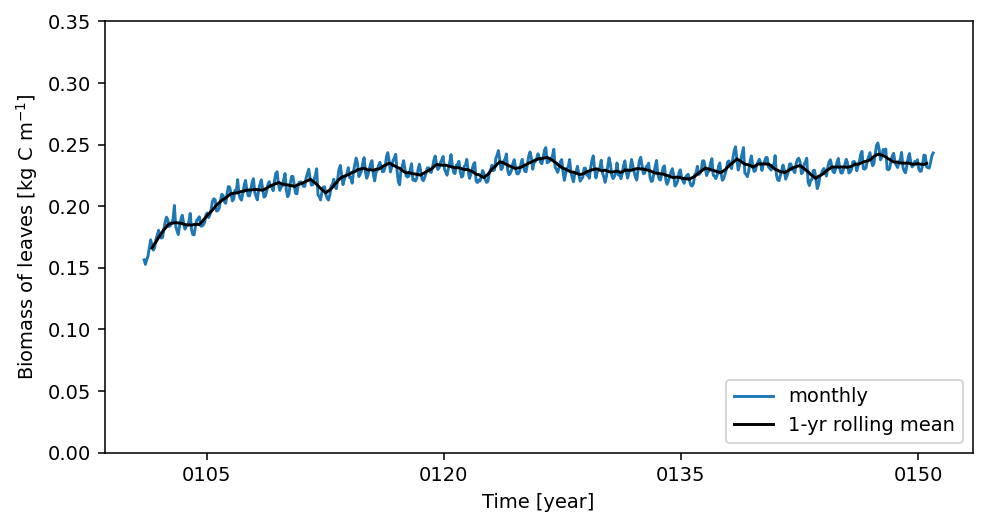

In [113]:
fig,ax = plt.subplots(figsize=(8,4))

biom_globmean.plot(ax=ax, label='monthly')
biom_globmean.rolling(time=12, center=True).mean().plot(ax=ax, c='k', label='1-yr rolling mean')
ax.set_ylabel('Biomass of leaves [kg C m$^{-1}$]')
ax.set_xlabel('Time [year]')
ax.legend(loc='lower right')
ax.set_ylim(0,0.35)

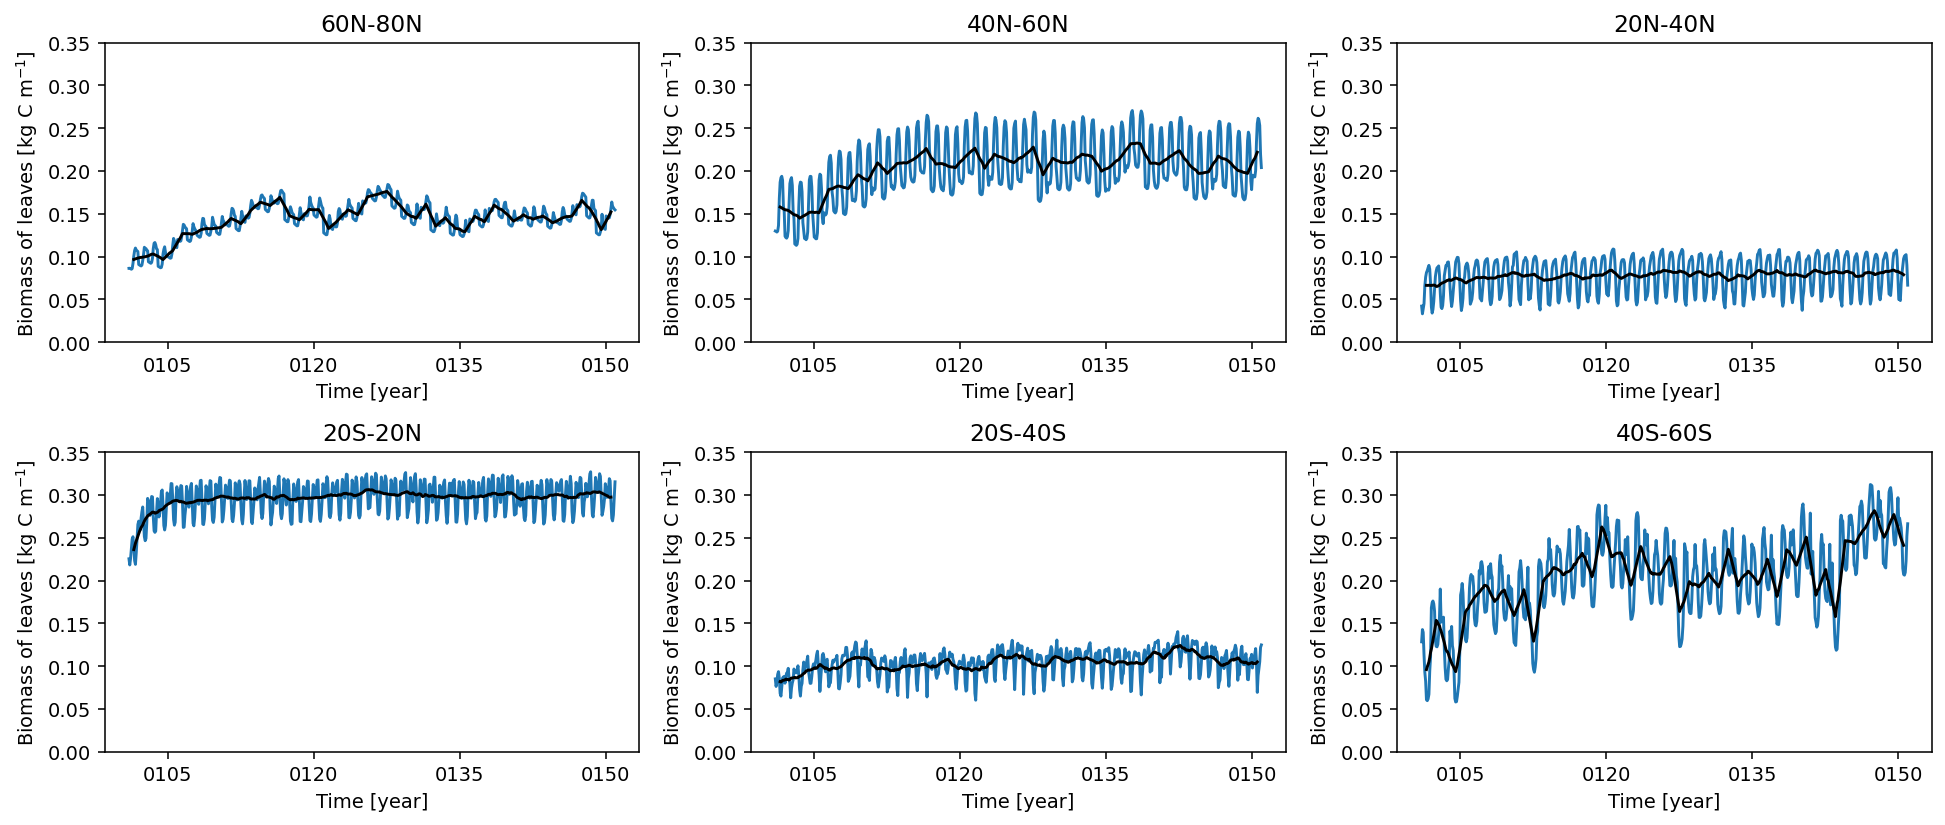

In [112]:
shgh = slice(-60,-40)
smid = slice(-40,-20)
trop = slice(-20,20)
nmid = slice(20,40)
nhgh = slice(40,60)
npol = slice(60,80)

fig,axes = plt.subplots(2, 3, figsize=(14,6))
ax = axes.ravel()

# peaks in JAS
biom_zonal.sel(grid_yt=npol).mean(dim='grid_yt').plot(ax=ax[0], label='monthly')
biom_zonal.sel(grid_yt=npol).mean(dim='grid_yt').rolling(time=12, center=True).mean().plot(ax=ax[0], c='k', label='1-yr rolling mean')

biom_zonal.sel(grid_yt=nhgh).mean(dim='grid_yt').plot(ax=ax[1], label='monthly')
biom_zonal.sel(grid_yt=nhgh).mean(dim='grid_yt').rolling(time=12, center=True).mean().plot(ax=ax[1], c='k', label='1-yr rolling mean')

biom_zonal.sel(grid_yt=nmid).mean(dim='grid_yt').plot(ax=ax[2], label='monthly')
biom_zonal.sel(grid_yt=nmid).mean(dim='grid_yt').rolling(time=12, center=True).mean().plot(ax=ax[2], c='k', label='1-yr rolling mean')

biom_zonal.sel(grid_yt=trop).mean(dim='grid_yt').plot(ax=ax[3], label='monthly')
biom_zonal.sel(grid_yt=trop).mean(dim='grid_yt').rolling(time=12, center=True).mean().plot(ax=ax[3], c='k', label='1-yr rolling mean')

biom_zonal.sel(grid_yt=smid).mean(dim='grid_yt').plot(ax=ax[4], label='monthly')
biom_zonal.sel(grid_yt=smid).mean(dim='grid_yt').rolling(time=12, center=True).mean().plot(ax=ax[4], c='k', label='1-yr rolling mean')

biom_zonal.sel(grid_yt=shgh).mean(dim='grid_yt').plot(ax=ax[5], label='monthly')
biom_zonal.sel(grid_yt=shgh).mean(dim='grid_yt').rolling(time=12, center=True).mean().plot(ax=ax[5], c='k', label='1-yr rolling mean')


ax[0].set_title('60N-80N')
ax[1].set_title('40N-60N')
ax[2].set_title('20N-40N')
ax[3].set_title('20S-20N')
ax[4].set_title('20S-40S')
ax[5].set_title('40S-60S')

for a in ax:
    a.set_ylabel('Biomass of leaves [kg C m$^{-1}$]')
    a.set_xlabel('Time [year]')
    a.set_ylim(0,0.35)

fig.tight_layout()

In [100]:
tran_zonal = getzonal(tran) * 86400
tran_globmean = getglobmean(tran) * 86400

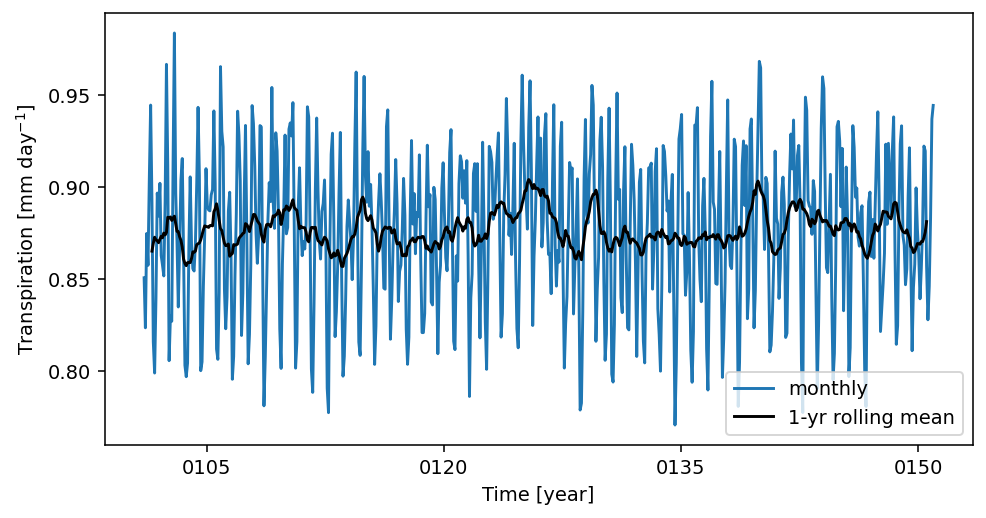

In [103]:
fig,axes = plt.subplots(figsize=(8,4))

tran_globmean.plot(ax=ax, label='monthly')
tran_globmean.rolling(time=12, center=True).mean().plot(ax=ax, c='k', label='1-yr rolling mean')
ax.set_ylabel('Transpiration [mm day$^{-1}$]')
ax.set_xlabel('Time [year]')
ax.legend(loc='lower right')

## SST init conditions

In [5]:
sst_init = xr.open_dataset('/tigress/wenchang/HIRAM/input_wy/FROM_AM4_default_input/v201906/hadisst_sst.clim.1986-2005.repeat.nc')['sst']
sst_plus2k_init = xr.open_dataset('/tigress/wenchang/HIRAM/input_wy/FROM_AM4_default_input/v201906/hadisst_sst.clim.1986-2005.repeat.plus2K.nc')['sst']

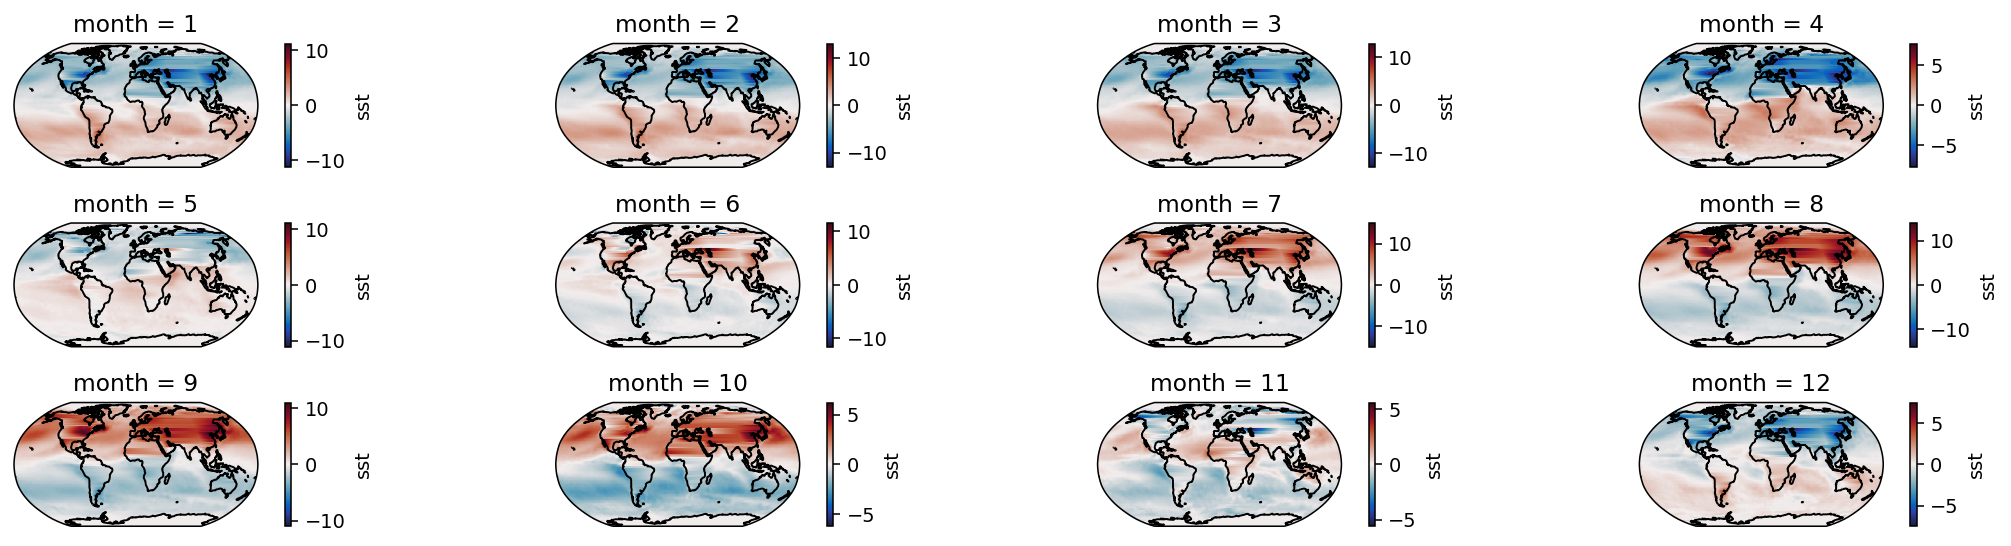

In [10]:
map_proj = ccrs.Robinson()

fig,axes = plt.subplots(3,4,figsize=(16,4),subplot_kw={'projection': map_proj})
ax = axes.ravel()

monthly_sst = sst_init.groupby('time.month').mean()
for m in range(12):
    (monthly_sst.isel(month=m)-sst_init.mean(dim='time')).plot(ax=ax[m], transform=ccrs.PlateCarree(), cmap=cmo.balance)
    ax[m].coastlines()
    
fig.tight_layout()

In [13]:
co2x1 = getoutput('CTL1990s_1xCO2', 'atmos_month', getAll=True)
# vegnco2x2 = getoutput('CTL1990s_vegn2xCO2', 'atmos_month', getAll=True)
co2x2_plus2k = getoutput('CTL1990s_2xCO2_plus2K', 'atmos_month', getAll=True)
# physco2x2_plus2k = getoutput('CTL1990s_phys2xCO2_plus2K', 'atmos_month', getAll=True)

/home/bgb2/miniconda3/envs/itcz_phys/lib/python3.11/site-packages/xarray/coding/times.py:716: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/bgb2/miniconda3/envs/itcz_phys/lib/python3.11/site-packages/xarray/coding/times.py:716: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/bgb2/miniconda3/envs/itcz_phys/lib/python3.11/site-packages/xarray/coding/times.py:716: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/hom

In [15]:
ice_mask = xr.where(co2x2_plus2k['ice_mask'].isel(time=0)>0.15, 1, 0)

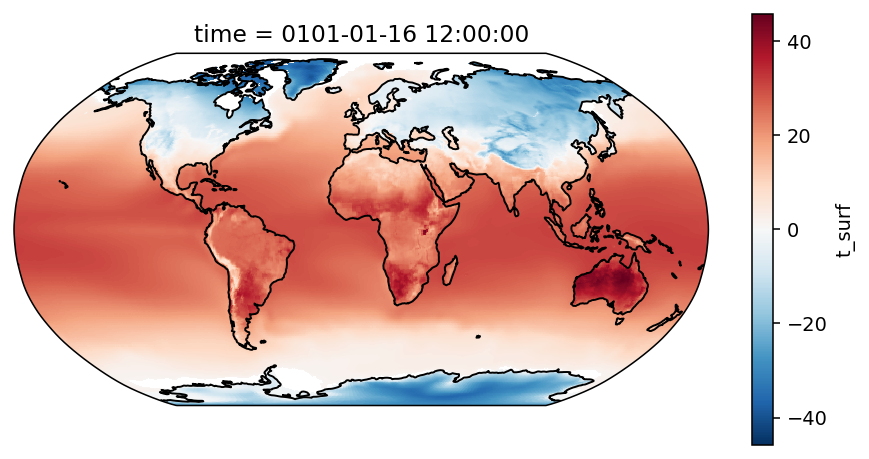

In [35]:
map_proj = ccrs.Robinson()
fig,ax = plt.subplots(figsize=(8,4), subplot_kw={'projection': map_proj})

(co2x2_plus2k['t_surf'].isel(time=0)-273.15).where(ice_mask == 0).plot(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines()

Text(0.5, 1.0, '(co2x2_plus2K) $-$ (co2x1)')

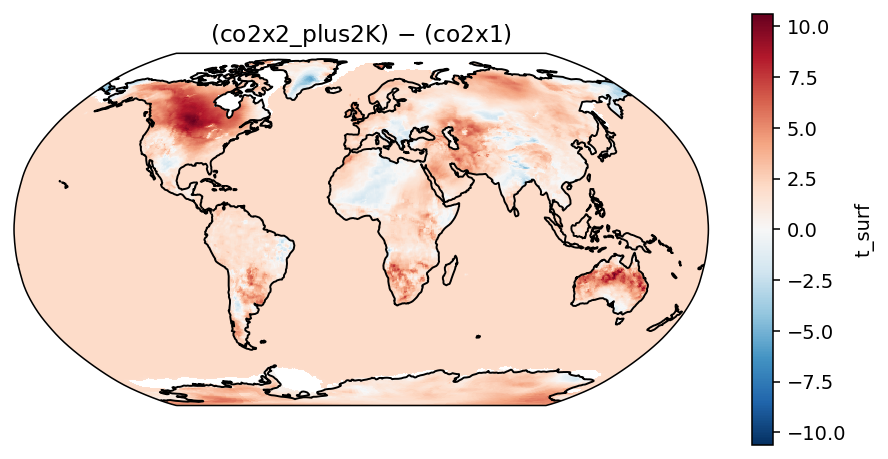

In [37]:
map_proj = ccrs.Robinson()
fig,ax = plt.subplots(figsize=(8,4), subplot_kw={'projection': map_proj})

(co2x2_plus2k['t_surf'].isel(time=0) - co2x1['t_surf'].isel(time=0)).where(ice_mask == 0).plot(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('(co2x2_plus2K) $-$ (co2x1)')

Text(0.5, 1.0, '[(2xCO2_plus2K) $-$ (1xCO2)] == 2')

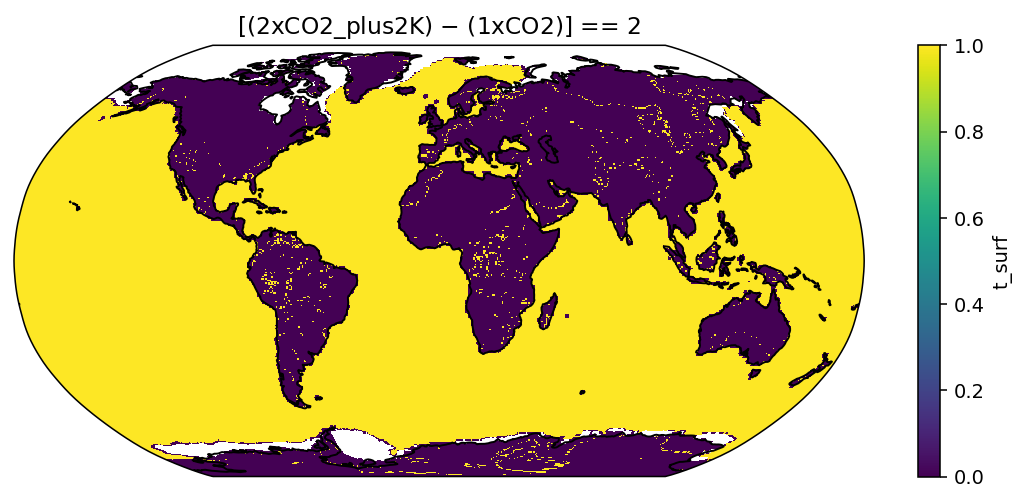

In [41]:
map_proj = ccrs.Robinson()
fig,ax = plt.subplots(figsize=(10,4), subplot_kw={'projection': map_proj})

(np.around((co2x2_plus2k['t_surf'].isel(time=0) - co2x1['t_surf'].isel(time=0)), decimals=1) == 2).where(ice_mask == 0).plot(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title('[(2xCO2_plus2K) $-$ (1xCO2)] == 2')

## Grid cell area

In [87]:
R = 6378.137e3 # [m]
nlat = 360
nlon = 576
area = np.zeros((nlat,nlon))
latdiff = (lat.values[1:] - lat.values[:-1])[0]
londiff = (lon.values[1:] - lon.values[:-1])[0]
lat_bnds = np.concatenate((np.reshape(lat.values, (nlat, 1)) - latdiff/2, np.reshape(lat.values, (nlat, 1)) + latdiff/2), axis=1)
lon_bnds = np.concatenate((np.reshape(lon.values, (nlon, 1)) - londiff/2, np.reshape(lon.values, (nlon, 1)) + londiff/2), axis=1)

for lt in range(lat_bnds.shape[0]):
    lat1 = np.deg2rad(lat_bnds[lt,0])
    lat2 = np.deg2rad(lat_bnds[lt,1])
    for ln in range(lon_bnds.shape[0]):
        lon1 = np.deg2rad(lon_bnds[ln,0])
        lon2 = np.deg2rad(lon_bnds[ln,1])
        area[lt,:] = 2*np.pi*(R**2)*np.abs(np.sin(lat1)-np.sin(lat2))*np.abs(lon1-lon2)/360